In [ ]:
import math
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def getClearLogs(experiment_logs):
  experiment_data = []
  for log in experiment_logs:
    cleared_log = log.split("[JavaFX Application Thread] ")
    cleared_log.pop(0)
    if (len(cleared_log) >= 1) and ("Experiment" in cleared_log[0]):
      experiment_data.append(cleared_log)
  return experiment_data

In [ ]:
def getExperimentInfo(experiment_logs):
  experiment_info = {
      "Size X": [],
      "Size Y": [],
      "Num of idling zones": [],
      "Num of agents": [],
      "Idling zone percentage": [],
      "Idling zone dist": [],
      "Completed orders": []

  }

  for log in experiment_logs:
    splitted_logs = log[0].split(" - ")
    if len(splitted_logs) >= 1 and splitted_logs[1] == "Grid":
      experiment_info_logs = splitted_logs[2].split(",")
      size_x = int(experiment_info_logs[0].split(":")[1])
      size_y = int(experiment_info_logs[1].split(":")[1])
      num_of_idling_zone = int(experiment_info_logs[2].split(":")[1])
      num_of_agents = int(experiment_info_logs[3].split(":")[1])
      idling_zone_percentage = int((num_of_idling_zone/num_of_agents)*100)
      if size_x == 41:
        idling_zone_percentage = math.ceil((math.ceil(num_of_idling_zone / 1.95)/math.ceil(num_of_agents / 3.81))*100)
      experiment_info["Size X"].append(size_x)
      experiment_info["Size Y"].append(size_y)
      experiment_info["Num of idling zones"].append(num_of_idling_zone)
      experiment_info["Num of agents"].append(num_of_agents)
      experiment_info["Idling zone percentage"].append(idling_zone_percentage)
      experiment_info["Idling zone dist"].append(experiment_info_logs[4].split(":")[1])
    elif len(splitted_logs) >= 1 and splitted_logs[1] == "Result":
      result_info_log = splitted_logs[2].split(",")
      experiment_info["Completed orders"].append(int(result_info_log[0].split(":")[1]))
  return experiment_info

def getExperimentByType(size_x, idling_zone_percentage):
  title = "Experiment with grid size " + str(size_x) + "x" + str(size_x) + " and idling zone percentage of " + str(idling_zone_percentage) 
  return df.loc[(df['Size X'] == size_x) & ((df['Idling zone percentage'] == idling_zone_percentage) | (df['Idling zone percentage'] == idling_zone_percentage-1))], title

def getExperimentResult(df):
  random = df.loc[df['Idling zone dist'] == "RANDOM"]
  distributed = df.loc[df['Idling zone dist'] == "DISTRIBUTED_BORDER"]
  nearest = df.loc[df['Idling zone dist'] == "NEAREST_BORDER"]
  random_border = df.loc[df['Idling zone dist'] == "RANDOM_BORDER"]
  return random, distributed, nearest, random_border

def getMaxIdlingZonePoint(df, distribution, size_x):
  if size_x == 41:
    if distribution == "Distributed Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= int(40.5 * 3.81))]
    elif distribution == "Nearest Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= int(70.25 * 3.81))]
    elif distribution == "Random Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= int(71.28 * 3.81))]
  elif size_x == 21:
    if distribution == "Distributed Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= 39)]
    elif distribution == "Nearest Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= 67)]
    elif distribution == "Random Border":
      maxIdlingZonePointData = df.loc[(df["Size X"] == size_x) & (df['Num of agents'] >= 69)]
  return maxIdlingZonePointData.iloc[0]


def plotExperiment(size_x, idling_zone_percentage):
  experiment_df, title = getExperimentByType(size_x, idling_zone_percentage)
  random, distributed, nearest, random_border = getExperimentResult(experiment_df)
  agent_count_scale = int(100/idling_zone_percentage)
  plt.plot(random["Num of agents"], random["Completed orders"], color="blue", label="Random", linestyle="--",  marker="o", )
  plt.plot(distributed["Num of agents"], distributed["Completed orders"], color="darkorange", label="Distributed Border", linestyle="--", marker="o")
  if size_x == 21:
    if 39*agent_count_scale <= 200:
      plt.axvline(x=39*agent_count_scale, color="darkorange", linestyle=':', ymin=0.1, ymax=0.9)
    if 67*agent_count_scale <= 200:
      plt.axvline(x=67*agent_count_scale, color="green", linestyle=':', ymin=0.1, ymax=0.9)
    if 69*agent_count_scale <= 200:
      plt.axvline(x=69*agent_count_scale, color="red", linestyle=':', ymin=0.1, ymax=0.9)
  elif size_x == 41:
    if int(40.5 * 3.81)*agent_count_scale <= 762:
      plt.axvline(x=int(40.5 * 3.81)*agent_count_scale, color="darkorange", linestyle=':', ymin=0.1, ymax=0.9)
    if int(70.25 * 3.81)*agent_count_scale <= 762:
      plt.axvline(x=int(70.25 * 3.81)*agent_count_scale, color="green", linestyle=':', ymin=0.1, ymax=0.9)
    if int(71.28 * 3.81)*agent_count_scale <= 762:
      plt.axvline(x=int(71.28 * 3.81)*agent_count_scale, color="red", linestyle=':', ymin=0.1, ymax=0.9)
  plt.plot(nearest["Num of agents"], nearest["Completed orders"], color="green", label="Nearest Border", linestyle="--", marker="o")
  plt.plot(random_border["Num of agents"], random_border["Completed orders"], color="red", label="Random Border", linestyle="--", marker="o")
  plt.legend()
  plt.xlabel("Number of Agents")
  plt.ylabel("Number of Completed Orders")
  plt.title(title)
  plt.show()


In [ ]:
f = open("logs.log", "r")
experiment_logs = f.read().split("\n")
cleared_logs = getClearLogs(experiment_logs)
experiment_info = getExperimentInfo(cleared_logs)
df = pd.DataFrame(experiment_info)
df = df.sort_values(by='Num of agents', ignore_index=True)

In [ ]:
df

,Size X,Size Y,Num of idling zones,Num of agents,Idling zone percentage,Idling zone dist,Completed orders
0,21,21,5,20,25,RANDOM,1008
1,21,21,20,20,100,RANDOM_BORDER,1040
2,21,21,10,20,50,RANDOM_BORDER,1161
3,21,21,5,20,25,RANDOM_BORDER,854
4,21,21,20,20,100,NEAREST_BORDER,1009
...,...,...,...,...,...,...,...
115,41,41,390,762,100,DISTRIBUTED_BORDER,1600
116,41,41,390,762,100,NEAREST_BORDER,1606
117,41,41,97,762,25,NEAREST_BORDER,1501
118,41,41,97,762,25,RANDOM,2710


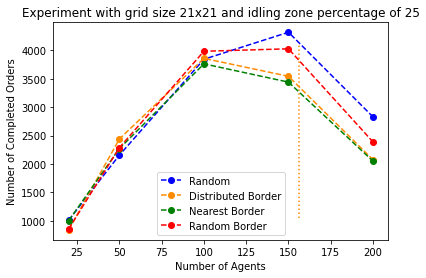

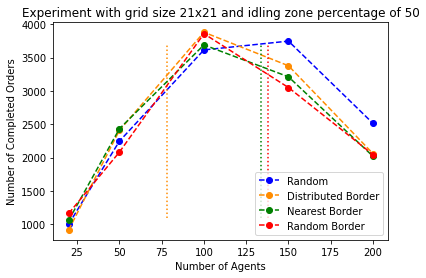

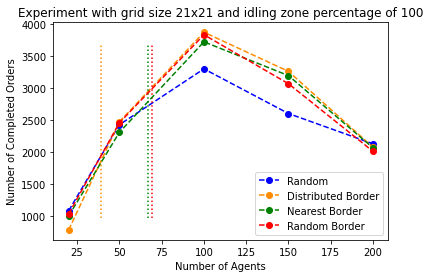

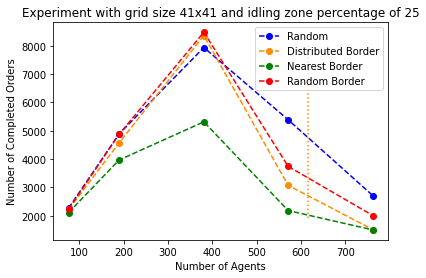

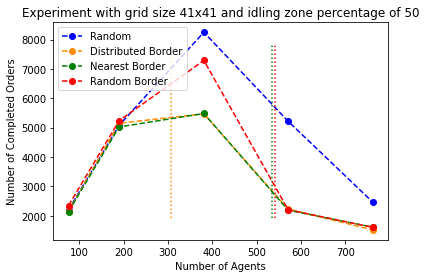

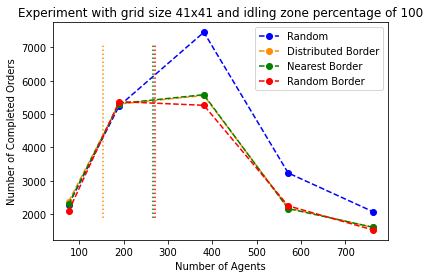

In [ ]:
plotExperiment(21, 25)
plotExperiment(21, 50)
plotExperiment(21, 100)
plotExperiment(41, 25)
plotExperiment(41, 50)
plotExperiment(41, 100)